2025-11-09 09:21:38.404624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762680098.619319      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762680098.679767      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-09 09:21:52.573227: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.0571 - loss: 3.1354 - val_accuracy: 0.1080 - val_loss: 2.9090
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1538 - loss: 2.7770 - val_accuracy: 0.3920 - val_loss: 2.0680
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3685 - loss: 1.8909 - val_accuracy: 0.7102 - val_loss: 1.3000
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5974 - loss: 1.3026 - val_accuracy: 0.6989 - val_loss: 0.8990
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7078 - loss: 0.9081 - val_accuracy: 0.8182 - val_loss: 0.6159
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7937 - loss: 0.6609 - val_accuracy: 0.8636 - val_loss: 0.4492
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8556 - loss: 0.5095 - val_accuracy: 0.8580 - val_loss: 0.4108
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8708 - loss: 0.4374 - val_accuracy: 0

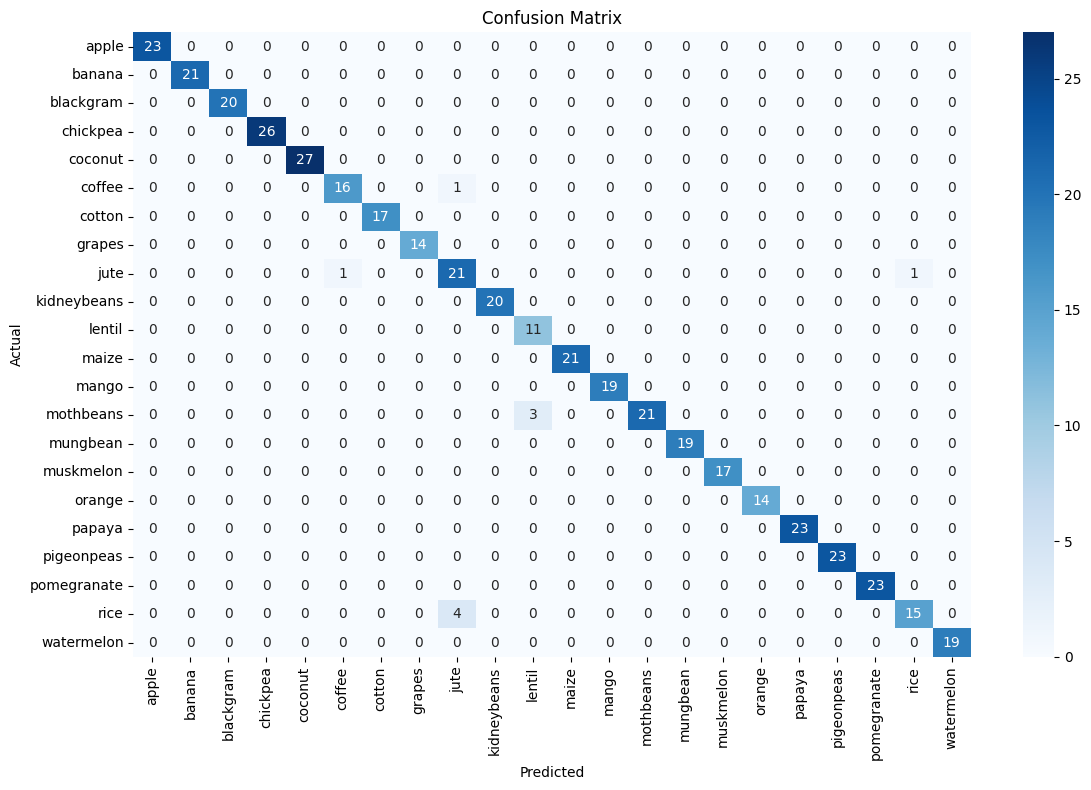

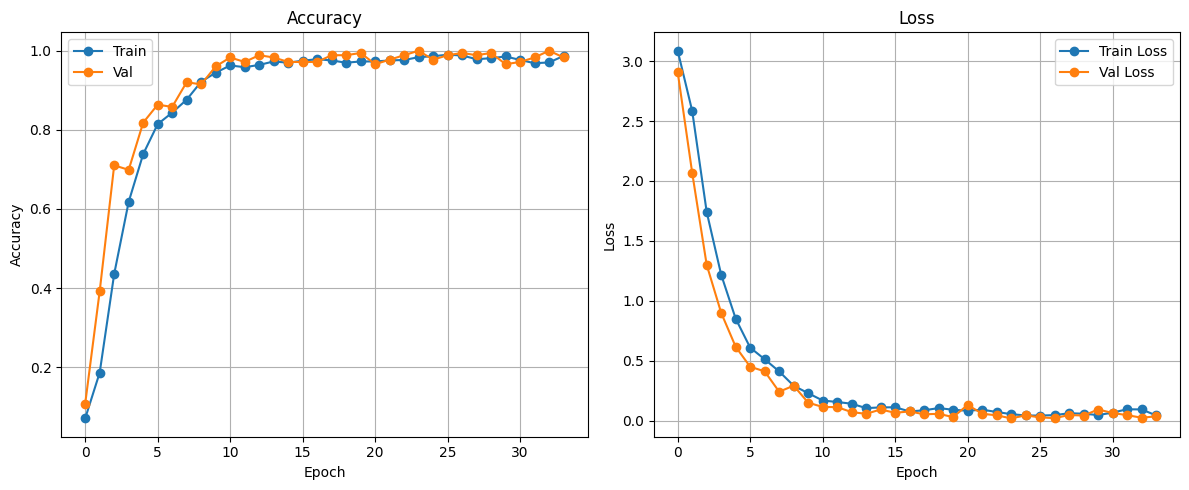

In [1]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GRU, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# 2. Define Hybrid Model: MLP/CNN → Transformer → GRU
def hybrid_featuretoken_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, use_gru=True):
    inp = Input(shape=input_shape)

    # Feature extractor: MLP or CNN
    x = Conv1D(filters=d_model, kernel_size=1, activation='relu')(inp)

    # Transformer Block (feature token attention)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # GRU / LSTM block
    if use_gru:
        x = GRU(64)(x)
    else:
        x = LSTM(64)(x)

    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = hybrid_featuretoken_transformer(input_shape=(7, 1), num_classes=y_cat.shape[1], use_gru=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[early_stop], verbose=1)

# 4. Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import shap
import lime
import lime.lime_tabular
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ------------------------
# 7. SHAP Explainability
# ------------------------
print("SHAP Explainability:")

X_flat = X_scaled  # shape: (samples, 7)

# Use a subset for SHAP to keep it fast
sample_size = 100
X_sample = X_flat[:sample_size]

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(
    lambda x: model.predict(x.reshape(x.shape[0], 7, 1)),
    X_sample
)

# Compute SHAP values for the sample
shap_values = explainer.shap_values(X_sample)  # List: one array per class

# ---- Global Feature Importance ----
shap.summary_plot(shap_values, X_sample, feature_names=features)

# ---- Single Instance Waterfall Plot ----
instance_index = 0

# Get SHAP values for the instance (list: one array per class)
shap_values_single = explainer.shap_values(X_flat[instance_index:instance_index+1])

# Get predicted class index
pred_class = np.argmax(model.predict(X_flat[instance_index:instance_index+1].reshape(1, 7, 1)))

# Create waterfall plot for predicted class
shap.waterfall_plot(shap.Explanation(
    values=shap_values_single[pred_class][0],  # SHAP values for predicted class
    base_values=explainer.expected_value[pred_class],
    data=X_flat[instance_index],
    feature_names=features
))

# ---- Average SHAP Value Table & Bar Chart (for predicted class) ----
shap_df = pd.DataFrame(shap_values[pred_class], columns=features)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
print("\nAverage absolute SHAP values (Class: {}):\n".format(pred_class))
print(mean_abs_shap)

plt.figure(figsize=(6, 4))
mean_abs_shap.plot(kind='barh')
#plt.title("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.show()


# ------------------------
# 8. LIME Explainability
# ------------------------
print("LIME Explainability:")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_flat,
    feature_names=features,
    class_names=le.classes_,
    mode='classification'
)

lime_exp = explainer_lime.explain_instance(
    data_row=X_flat[instance_index],
    predict_fn=lambda x: model.predict(x.reshape(x.shape[0], 7, 1)),
    num_features=7
)
lime_exp.show_in_notebook()


# ------------------------
# 9. Save model
# ------------------------
model.save('/mnt/data/cnn_transformer_gru_model.h5')
print("Model saved as 'cnn_transformer_gru_model.h5'")


SHAP Explainability:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
394/394 ━━━━━━

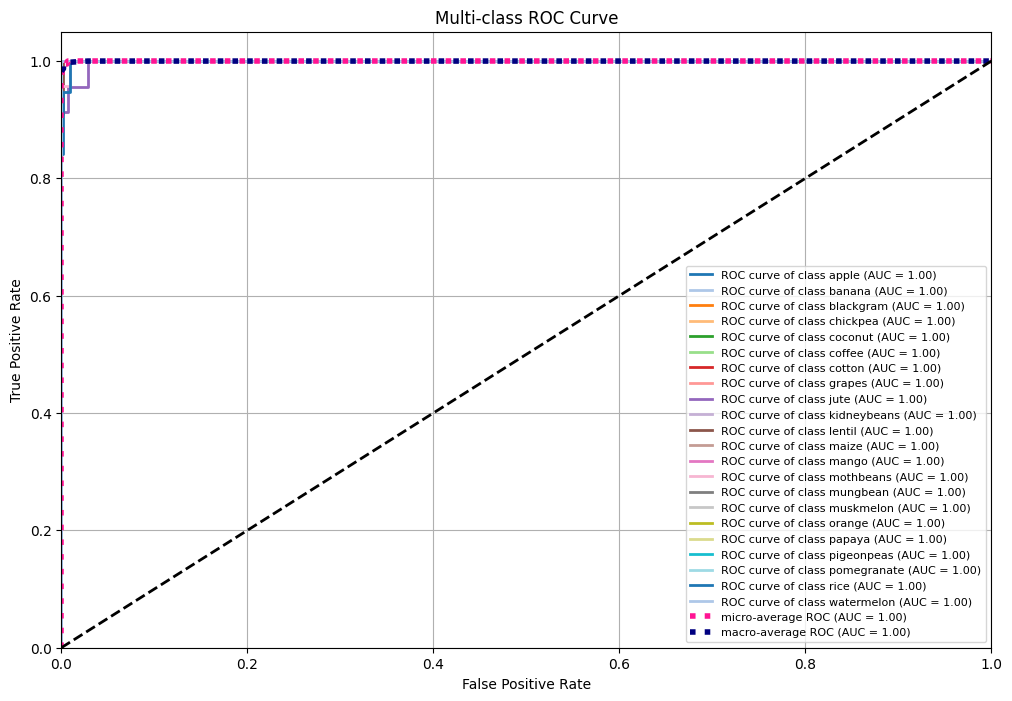

In [4]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# One-hot true labels
y_test_bin = y_test
y_score = y_pred_probs

n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC
# Aggregate all FPR points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC Curves
plt.figure(figsize=(12, 8))

# Plot per-class ROC
colors = cycle(plt.cm.tab20.colors)  # Distinct colors for many classes
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Plot micro and macro averages
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
    color='deeppink', linestyle=':', linewidth=4
)
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
    color='navy', linestyle=':', linewidth=4
)

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right', fontsize=8)
plt.grid()
plt.show()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0693 - loss: 3.1279 - val_accuracy: 0.1307 - val_loss: 2.7318
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1814 - loss: 2.5341 - val_accuracy: 0.3807 - val_loss: 1.7760
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4243 - loss: 1.7099 - val_accuracy: 0.7045 - val_loss: 1.1957
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6348 - loss: 1.1766 - val_accuracy: 0.7443 - val_loss: 0.8106
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6923 - loss: 0.9373 - val_accuracy: 0.8011 - val_loss: 0.6528
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7436 - loss: 0.7404 - val_accuracy: 0.8295 - val_loss: 0.5524
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8180 - loss: 0.5792 - val_accuracy: 0.8864 - val_loss: 0.3623
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8849 - loss: 0.4049 - val_accuracy: 0

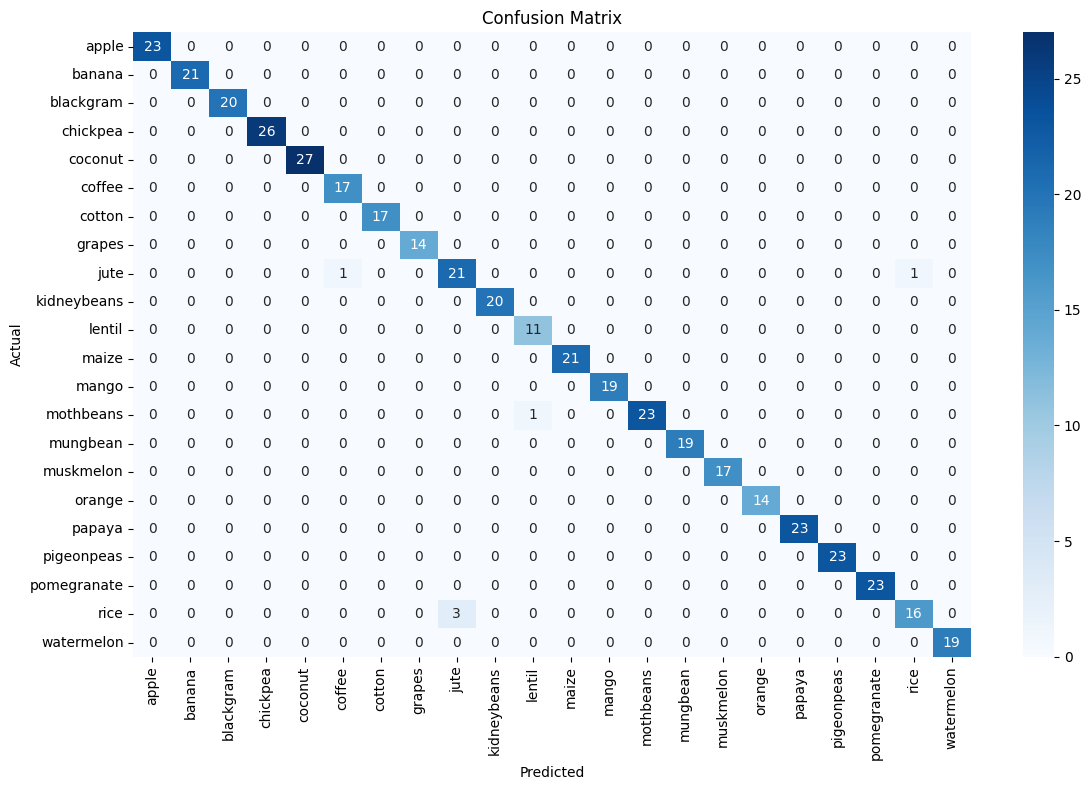

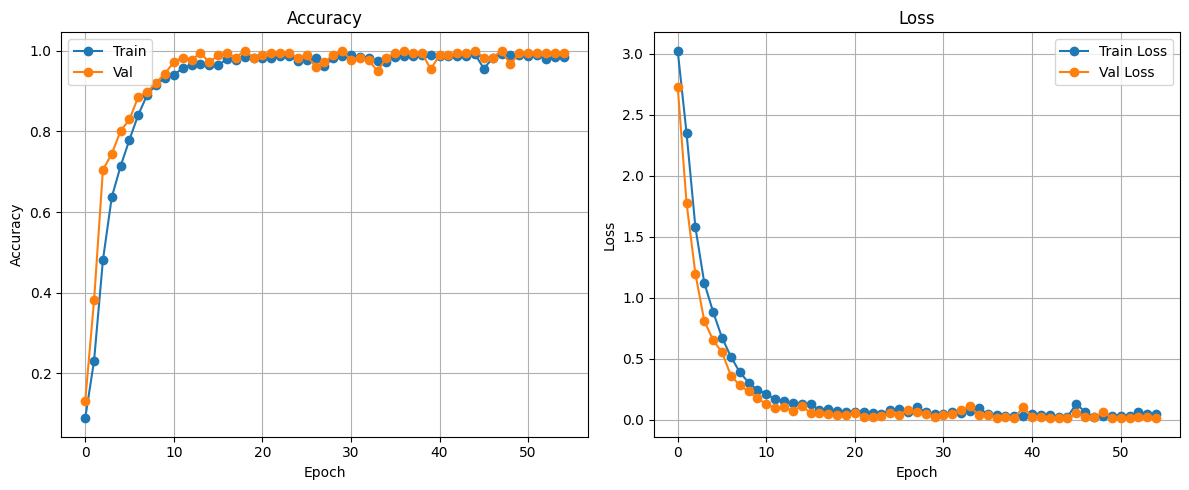

In [7]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GRU, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# 2. Define Hybrid Model: MLP/CNN → Transformer → GRU
def hybrid_featuretoken_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, use_gru=True):
    inp = Input(shape=input_shape)

    # Feature extractor: MLP or CNN
    x = Conv1D(filters=d_model, kernel_size=1, activation='relu')(inp)

    # Transformer Block (feature token attention)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # GRU / LSTM block
    if use_gru:
        x = GRU(64)(x)
    else:
        x = LSTM(64)(x)

    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = hybrid_featuretoken_transformer(input_shape=(7, 1), num_classes=y_cat.shape[1], use_gru=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[early_stop], verbose=1)

# 4. Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss     : {loss:.4f}")
print(f"Test Accuracy : {acc:.4f}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 5. Classification Report (4 decimal precision)
report_dict = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.round(4)
print("\nClassification Report:")
print(report_df)

# 6. R² Score
r2 = r2_score(y_test, y_pred_probs, multioutput='variance_weighted')
print(f"\nR² Score : {r2:.4f}")

# 7. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 8. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


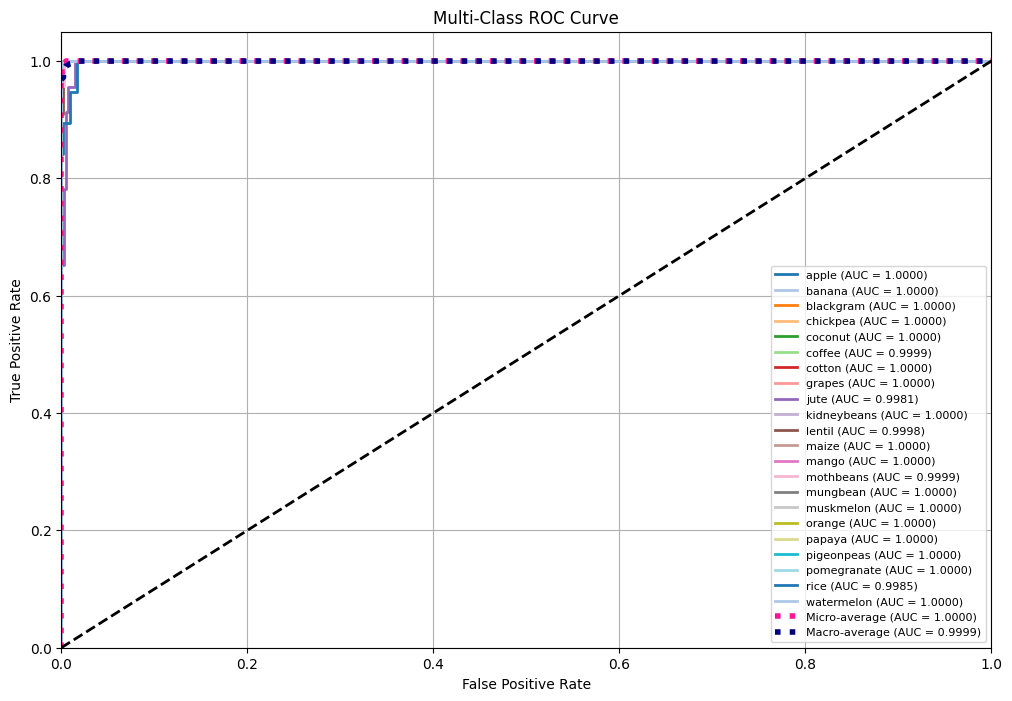


AUC Scores for Each Class:
          Class  AUC Score
0         apple     1.0000
1        banana     1.0000
2     blackgram     1.0000
3      chickpea     1.0000
4       coconut     1.0000
5        coffee     0.9999
6        cotton     1.0000
7        grapes     1.0000
8          jute     0.9981
9   kidneybeans     1.0000
10       lentil     0.9998
11        maize     1.0000
12        mango     1.0000
13    mothbeans     0.9999
14     mungbean     1.0000
15    muskmelon     1.0000
16       orange     1.0000
17       papaya     1.0000
18   pigeonpeas     1.0000
19  pomegranate     1.0000
20         rice     0.9985
21   watermelon     1.0000

Micro-average AUC : 1.0000
Macro-average AUC : 0.9999


In [8]:
# 9. ROC Curve & AUC Scores
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(plt.cm.tab20.colors)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right', fontsize=8)
plt.grid()
plt.show()

# Print AUC scores table
auc_df = pd.DataFrame({
    "Class": le.classes_,
    "AUC Score": [round(roc_auc[i], 4) for i in range(n_classes)]
})
print("\nAUC Scores for Each Class:")
print(auc_df)

print(f"\nMicro-average AUC : {roc_auc['micro']:.4f}")
print(f"Macro-average AUC : {roc_auc['macro']:.4f}")

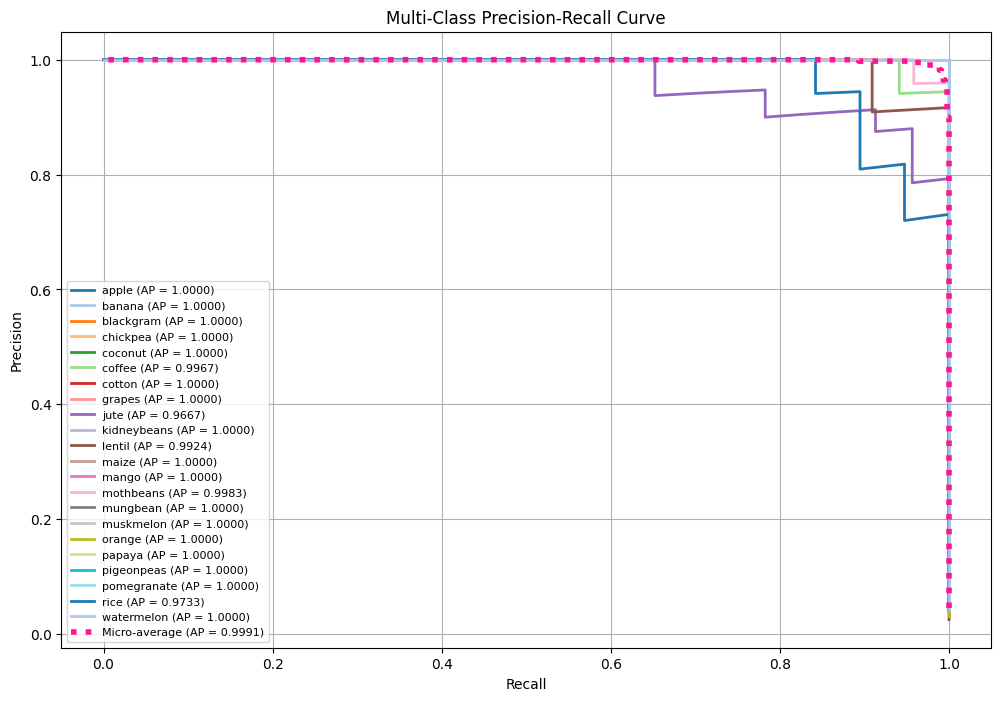


Average Precision (AP) Scores for Each Class:
          Class  Average Precision (AP)
0         apple                  1.0000
1        banana                  1.0000
2     blackgram                  1.0000
3      chickpea                  1.0000
4       coconut                  1.0000
5        coffee                  0.9967
6        cotton                  1.0000
7        grapes                  1.0000
8          jute                  0.9667
9   kidneybeans                  1.0000
10       lentil                  0.9924
11        maize                  1.0000
12        mango                  1.0000
13    mothbeans                  0.9983
14     mungbean                  1.0000
15    muskmelon                  1.0000
16       orange                  1.0000
17       papaya                  1.0000
18   pigeonpeas                  1.0000
19  pomegranate                  1.0000
20         rice                  0.9733
21   watermelon                  1.0000

Micro-average AP : 0.9991
Macro-

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 10. Precision-Recall Curves & Average Precision Scores
n_classes = y_test.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

# Compute precision-recall curve for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_probs[:, i])

# Micro-average PR curve
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_probs, average="micro")

# Macro-average AP score
average_precision["macro"] = np.mean([average_precision[i] for i in range(n_classes)])

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))
colors = cycle(plt.cm.tab20.colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AP = {average_precision[i]:.4f})')

plt.plot(recall["micro"], precision["micro"],
         color='deeppink', linestyle=':', linewidth=4,
         label=f'Micro-average (AP = {average_precision["micro"]:.4f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-Class Precision-Recall Curve")
plt.legend(loc="lower left", fontsize=8)
plt.grid()
plt.show()

# Print AP Scores Table
ap_df = pd.DataFrame({
    "Class": le.classes_,
    "Average Precision (AP)": [round(average_precision[i], 4) for i in range(n_classes)]
})
print("\nAverage Precision (AP) Scores for Each Class:")
print(ap_df)

print(f"\nMicro-average AP : {average_precision['micro']:.4f}")
print(f"Macro-average AP : {average_precision['macro']:.4f}")



📊 Model Performance Summary
Test Accuracy      : 0.9864
Test Loss          : 0.0396
R² Score           : 0.9772
Micro-average AUC  : 1.0000
Macro-average AUC  : 0.9999
Micro-average AP   : 0.9991
Macro-average AP   : 0.9967


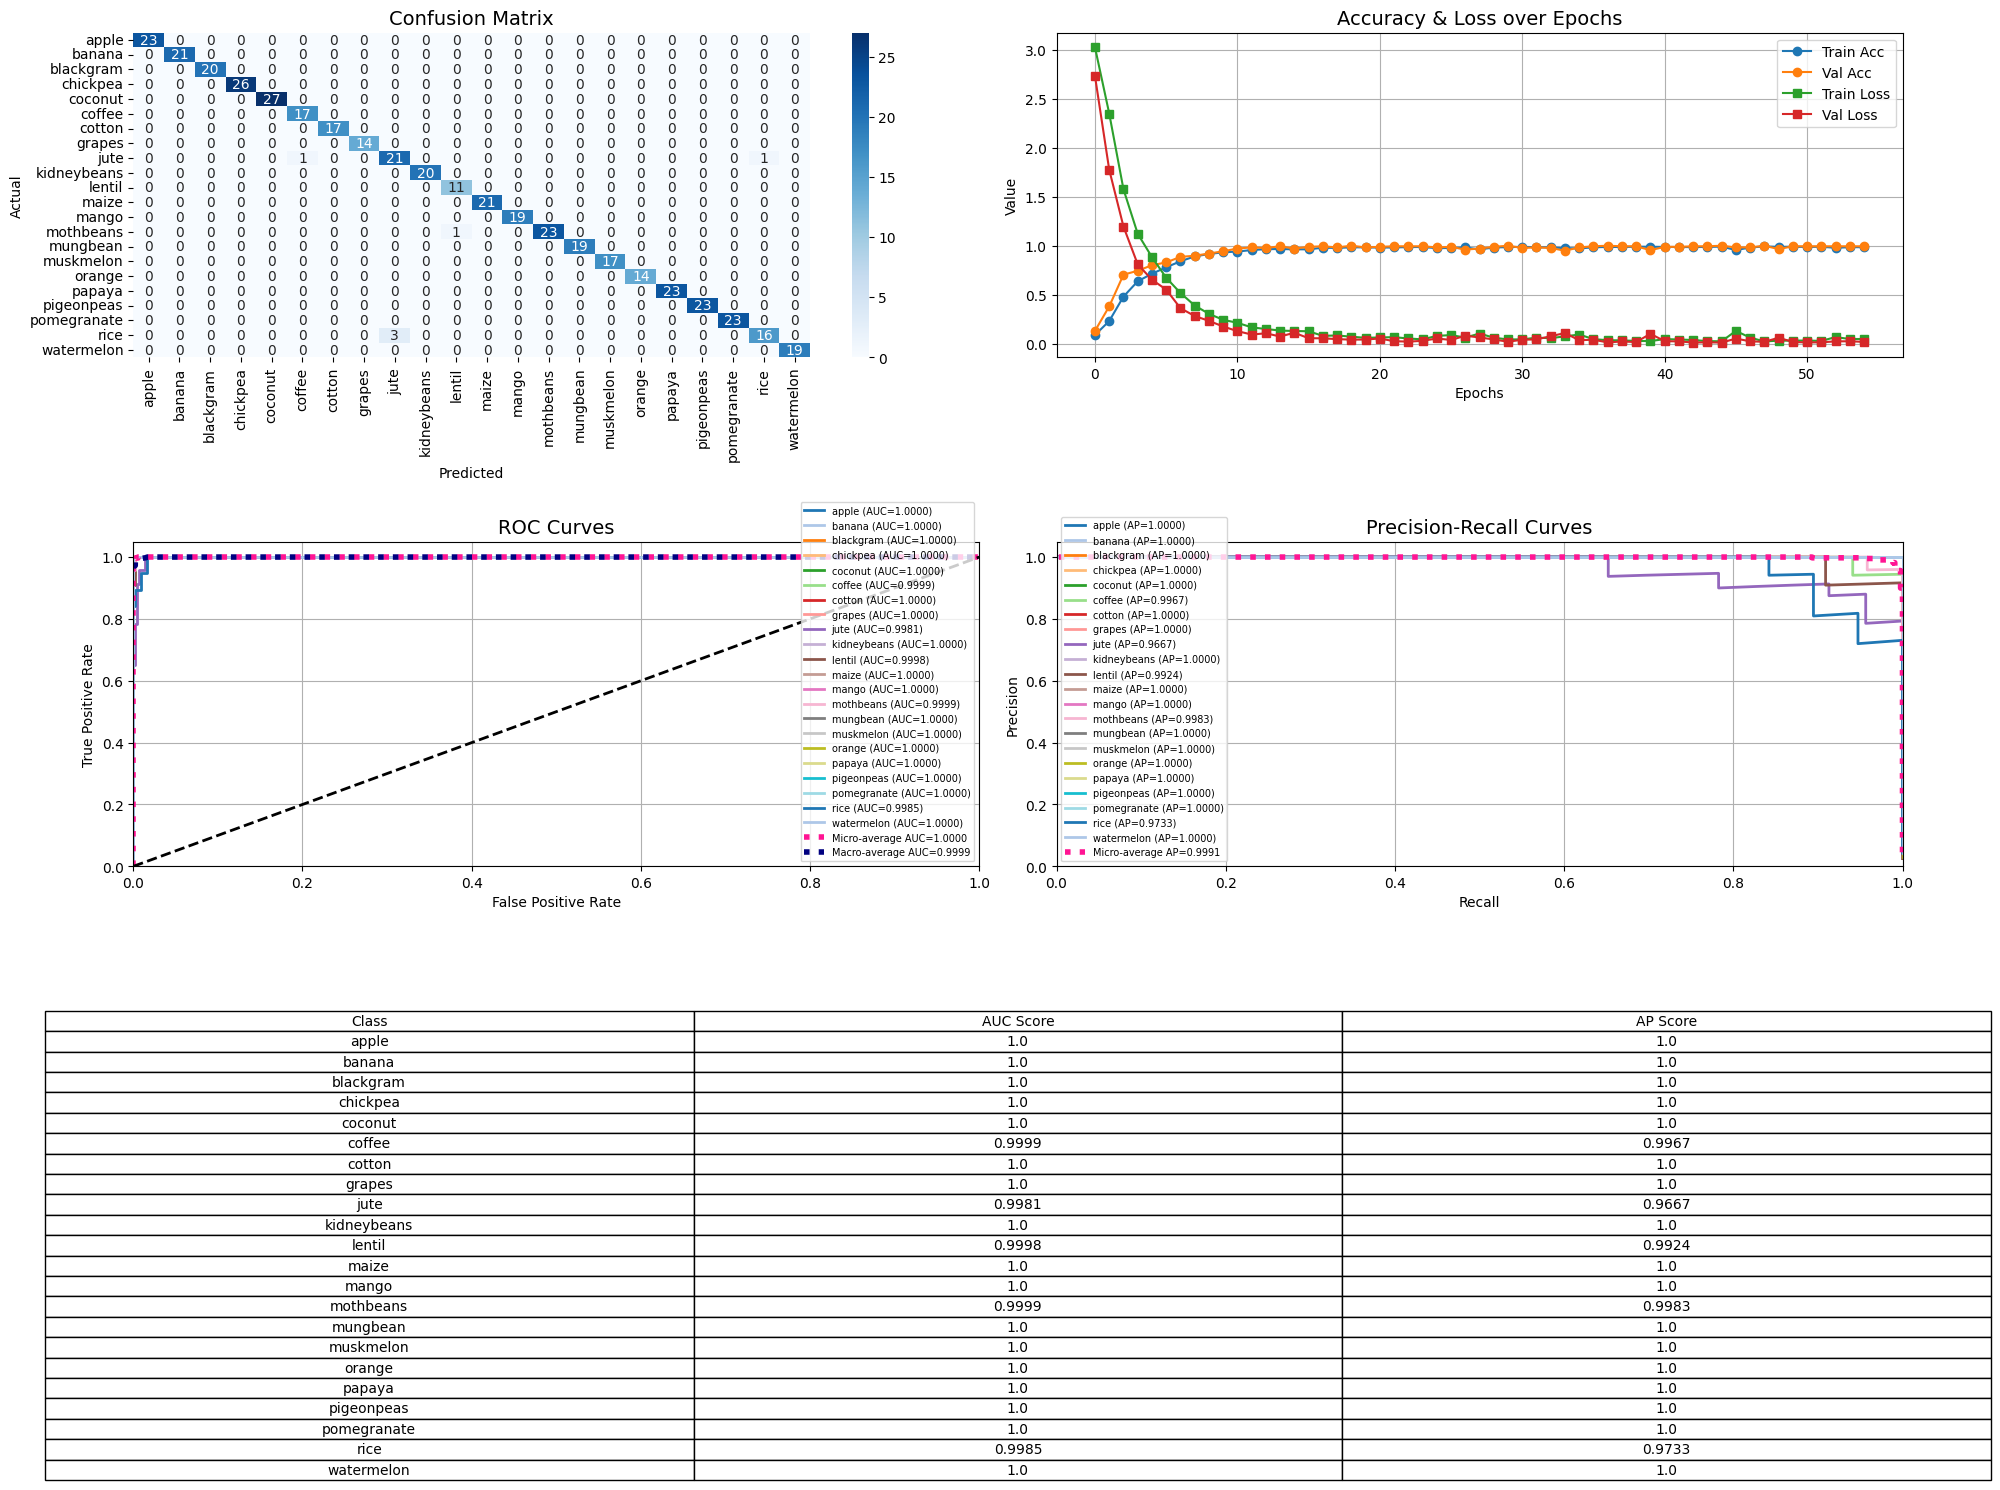

In [11]:
import matplotlib.gridspec as gridspec

# ==================== 1. Summary Metrics ==================== #
print("\n📊 Model Performance Summary")
print("="*50)
print(f"Test Accuracy      : {acc:.4f}")
print(f"Test Loss          : {loss:.4f}")
print(f"R² Score           : {r2:.4f}")
print(f"Micro-average AUC  : {roc_auc['micro']:.4f}")
print(f"Macro-average AUC  : {roc_auc['macro']:.4f}")
print(f"Micro-average AP   : {average_precision['micro']:.4f}")
print(f"Macro-average AP   : {average_precision['macro']:.4f}")
print("="*50)

# ==================== 2. Create Dashboard Layout ==================== #
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2])

# -------- A. Confusion Matrix -------- #
ax0 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax0)
ax0.set_title("Confusion Matrix", fontsize=14)
ax0.set_xlabel("Predicted")
ax0.set_ylabel("Actual")

# -------- B. Accuracy & Loss -------- #
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(history.history['accuracy'], label='Train Acc', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
ax1.plot(history.history['loss'], label='Train Loss', marker='s')
ax1.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax1.set_title("Accuracy & Loss over Epochs", fontsize=14)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid()

# -------- C. ROC Curve -------- #
ax2 = fig.add_subplot(gs[1, 0])
colors = cycle(plt.cm.tab20.colors)
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{le.classes_[i]} (AUC={roc_auc[i]:.4f})")
ax2.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f"Micro-average AUC={roc_auc['micro']:.4f}")
ax2.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label=f"Macro-average AUC={roc_auc['macro']:.4f}")
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.05])
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curves", fontsize=14)
ax2.legend(fontsize=7, loc="lower right")
ax2.grid()

# -------- D. Precision-Recall Curve -------- #
ax3 = fig.add_subplot(gs[1, 1])
colors = cycle(plt.cm.tab20.colors)
for i, color in zip(range(n_classes), colors):
    ax3.plot(recall[i], precision[i], color=color, lw=2,
             label=f"{le.classes_[i]} (AP={average_precision[i]:.4f})")
ax3.plot(recall["micro"], precision["micro"], color='deeppink',
         linestyle=':', linewidth=4, label=f"Micro-average AP={average_precision['micro']:.4f}")
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.05])
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.set_title("Precision-Recall Curves", fontsize=14)
ax3.legend(fontsize=7, loc="lower left")
ax3.grid()

# -------- E. AUC & AP Score Table -------- #
ax4 = fig.add_subplot(gs[2, :])
table_data = pd.DataFrame({
    "Class": le.classes_,
    "AUC Score": [round(roc_auc[i], 4) for i in range(n_classes)],
    "AP Score": [round(average_precision[i], 4) for i in range(n_classes)]
})

# Hide axes and show table
ax4.axis("tight")
ax4.axis("off")
table = ax4.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.2)
#ax4.set_title("AUC & AP Scores per Class", fontsize=14)

plt.tight_layout()
plt.show()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.0404 - loss: 3.0889 - val_accuracy: 0.0909 - val_loss: 3.0717
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0656 - loss: 3.0267 - val_accuracy: 0.1193 - val_loss: 2.6412
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1059 - loss: 2.5845 - val_accuracy: 0.1705 - val_loss: 2.1892
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1876 - loss: 2.2663 - val_accuracy: 0.4205 - val_loss: 1.8339
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3175 - loss: 1.9388 - val_accuracy: 0.5455 - val_loss: 1.4713
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3718 - loss: 1.6934 - val_accuracy: 0.5909 - val_loss: 1.2882
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4396 - loss: 1.5184 - val_accuracy: 0.6136 - val_loss: 1.1356
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4820 - loss: 1.3555 - val_accuracy: 0.

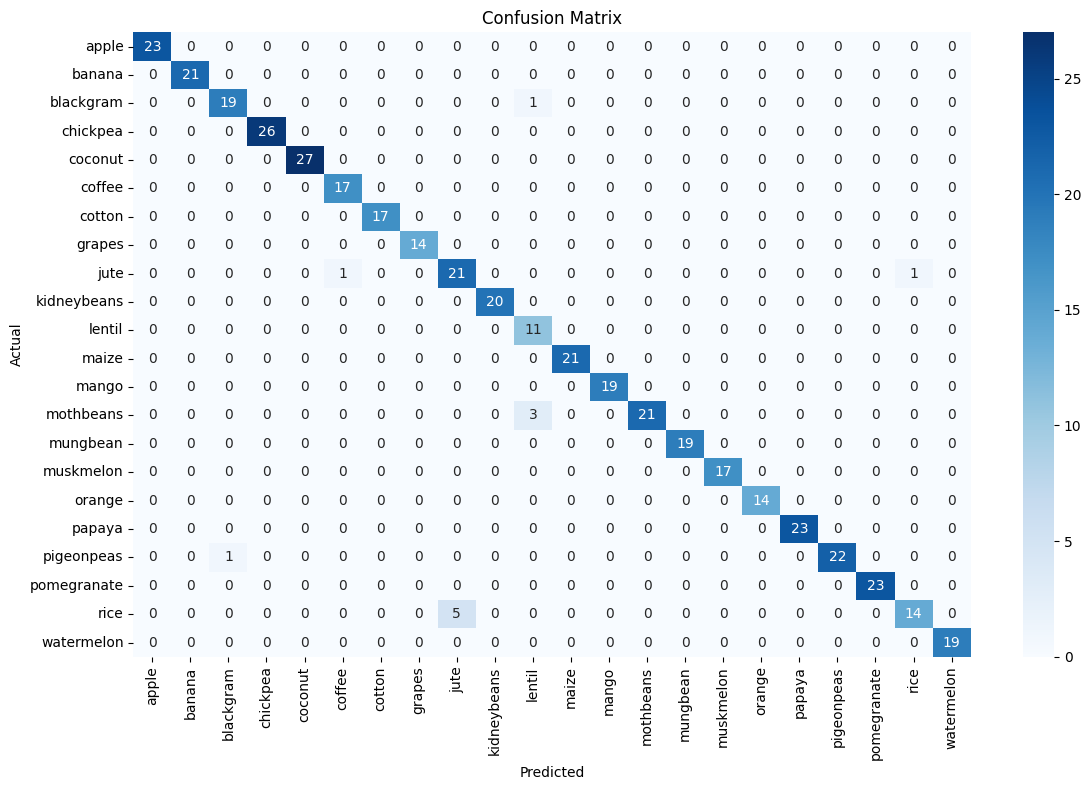

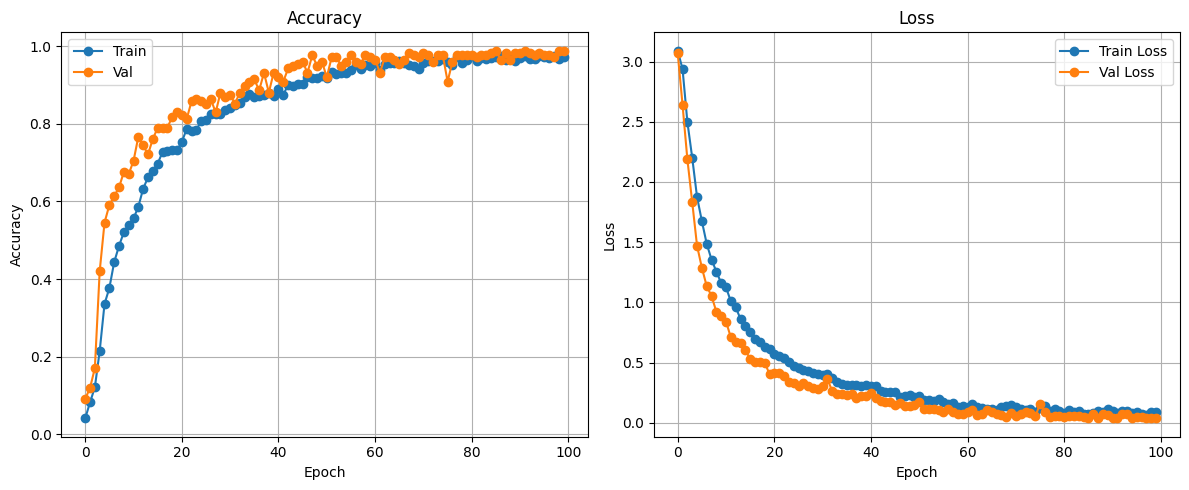

In [12]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess data
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, timesteps, features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# 2. Define GRU-only Model
def build_gru_model(input_shape, num_classes):
    inp = Input(shape=input_shape)

    # First GRU layer
    x = GRU(128, return_sequences=True)(inp)
    x = Dropout(0.3)(x)

    # Second GRU layer
    x = GRU(64)(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

# Build model
model = build_gru_model(input_shape=(7, 1), num_classes=y_cat.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, callbacks=[early_stop], verbose=1)

# 4. Evaluate model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss     : {loss:.4f}")
print(f"Test Accuracy : {acc:.4f}")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 5. Classification Report (4 decimal precision)
report_dict = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.round(4)
print("\nClassification Report:")
print(report_df)

# 6. R² Score
r2 = r2_score(y_test, y_pred_probs, multioutput='variance_weighted')
print(f"\nR² Score : {r2:.4f}")

# 7. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 8. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
